# TP Metric learning

Save the notebook as either PDF or HTML and make sure all the results are saved correctly (I won't run them and the original format does not save the results automatically), **and put your name in the filename**.

<div class="alert alert-success">
<b>Questions are in green boxes.</b>
The maximum time you should spend on each question is given as indication only. If you take more time than that, then you should come see me.
</div>
<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

In [1]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from functools import partial

For this lab, we will use the bluebell dataset. It consists of $64\times 64$ color images, which we will have to flatten into $12k$ dimensional vectors. The code for the dataset comes with several train/val/test splits, but in this notebook, we will use the first split and do our own cross-validation routines.

In [ ]:
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb

In [ ]:
# !unzip bluebell_64.zip


0


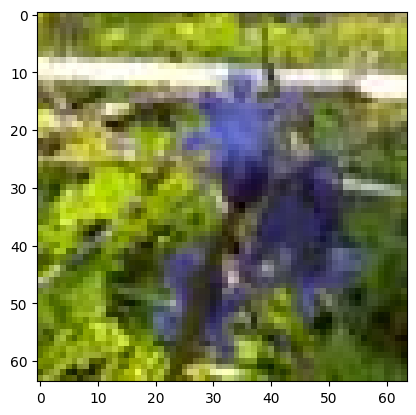

In [4]:
# Load the dataset
from bluebell import Bluebell
X_train_ds = Bluebell('bluebell_64', 'train', split=0)
X_val_ds = Bluebell('bluebell_64', 'val', split=0)
X_train = np.array([img.flatten()/127.5 - 1. for img, lab in X_train_ds])
y_train = np.array([lab for img, lab in X_train_ds])
X_val = np.array([img.flatten()/127.5 - 1. for img, lab in X_val_ds])
y_val = np.array([lab for img, lab in X_val_ds])
plt.imshow(X_train[0].reshape(64, 64, 3)/2+0.5)
print(y_train[0])

### Generic distance class

We start with a generic trainable distance class that serves as an interface for all the different distances we will implement. The `fit` method does the training.

In [5]:
class Distance():
    '''
    trains this distance function on a training set
    '''
    def fit(self, X, y):
        pass

    '''
    returns the distance between the sets X1 and X2:
    X1 is n x d (n samples of dimension d)
    X2 is m x d (n samples of dimension d)
    output is n x m (distance matrix)
    '''
    def predict(self, X1, X2):
        pass

## Implementing a $k$-Nearest-Neighbor

<div class="alert alert-success"> <b>Q1.</b> Implement a class that encapsulate the squared euclidean distance ($\| x_1 - x_2 \|^2$) using the Distance parent class. In this case, the `fit` method does nothing. <i>(Indicative time: about 10 minutes to code)</i>
</div>

In [6]:
class L2Distance(Distance):
    def __init__(self):
        super().__init__()

    def fit(self, X, y = None):
        pass
        # print('fitting...')
        # print('fitted!')


    def predict(self, X1, X2):
        norms1 = jnp.sum(jnp.square(X1), axis=1)
        norms2 = jnp.sum(jnp.square(X2), axis=1)
        D =  jnp.dot(X1, X2.T)
        return (norms2[None,:] + norms1[:,None] - 2*D)

<div class="alert alert-success"> <b>Q2.</b> Implement a $k$-NearestNeighbor class that relies on a Distance object to find the neighbors. It also trains the distance. Test it using your L2 Distance with $k=36$ (which should give about the same train and validation accuracy). <i>(Indicative time: about 30 minutes to code, runs in less than 15 seconds)</i>
</div>

In [7]:
import jax.nn as jnn
class KNN():
    def __init__(self, distance, k=1):
        self.distance = distance
        self.k = k
        self.X = None
        self.y = None

    '''
    trains the distance and memorizes the training set
    X: n x d (n samples of dimension d)
    y: n (n labels)
    '''
    def fit(self, X, y):
      output = self.distance.fit(X,y)
      self.y = jnn.one_hot(y, 12)
      self.X = X
      return output #to return losses
    '''
    predict the set of samples
    '''
    def predict(self, x):
        dist = self.distance.predict(x, self.X)
        indices = jnp.argsort(dist, axis=1)
        most_frequent_value = jnp.argmax((self.y[indices[:,0:self.k]]).sum(axis=1), axis=-1)
        return most_frequent_value

In [8]:
%%time
# Initialize the distance class
L2_distance = L2Distance()
L2_distance.fit(X_train)

knearestneighbor = KNN(distance = L2_distance , k = 36)
knearestneighbor.fit(X_train, y_train)
y_hat = knearestneighbor.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))

y_hat_val = knearestneighbor.predict(X_val)

accuracy = (y_hat_val==y_val).mean()
print("Accuracy in the validation set:", accuracy)


training error 0.4566666781902313
Accuracy in the validation set: 0.52000004
CPU times: user 2.87 s, sys: 520 ms, total: 3.39 s
Wall time: 3.69 s


<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>  Using this code achieves an accuracy of approximately 0.5200004 on the validation set, which is reasonably acceptable. However, the training error stands at 0.45. Since the current distance metric employed is the L2 distance, which does not encode any intrinsic similarities between the data points, there's significant room for improvement. Enhancing the model through metric learning could potentially lead to better performance by more effectively capturing the underlying relationships in the data.
</div>

<div class="alert alert-success"> <b>Q3.</b>  Implement a trainable $\ell_2$ distance function. It performs a linear projection $P$ such that the distance between similar samples is minimized, trained using gradient descent:

$$ \min_P \sum_{x, x_p, y = y_p} \|Px - Px_p\|^2 $$

To reduce the cost of the update, perform the gradient descent on mini-batches of 50 samples taken randomly within the training set. Use 64 output dimensions. Plot the loss curve. <i>(Indicative time: about 30 minutes to code, runs for about 30 seconds for 2000 iterations)</i>
</div>

In [30]:
class L2MinDistance(Distance):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
    @staticmethod
    @jax.jit
    def dist(X1, X2):
        norms1 = jnp.sum(jnp.square(X1), axis=1)
        norms2 = jnp.sum(jnp.square(X2), axis=1)
        D =  jnp.dot(X1, X2.T)
        return (norms2[None,:] + norms1[:,None] - 2*D)

    @staticmethod
    @jax.jit
    def loss(P, X, y):
        # Project all data points
        X_projected = X @ P
        sq_distances = L2MinDistance.dist(X_projected, X_projected)
        # Create a mask :
        same_label = (y[:,None] == y[None,:])
        loss = jnp.mean(sq_distances * same_label)
        return loss



    @staticmethod
    @jax.jit #that made it run faster
    def update(P, X, y, eta=0.01):
        l, dp = jax.value_and_grad(L2MinDistance.loss, argnums=0)(P, X, y)
        return l,  P -eta*dp

    def fit(self, X, y):
          N = len(y)
          epochs = 3  #to have
          num_batches = (N + 50 -1 )//50
          losses = jnp.zeros(80)
          for i in range(80):
              perm_indices = jax.random.permutation(jax.random.PRNGKey(i), N)
              epoch_losses = []
              for k in range(num_batches) :
                      indices = perm_indices[k*50 : min((k+1)*50,N)]
                      batch_loss, self.P = self.update(self.P, X[indices], y[indices])
                      epoch_losses.append(batch_loss)

              sum_loss = jnp.mean(jnp.array(epoch_losses))
              losses = losses.at[i].set(sum_loss)
              if i%10 == 0 :
                print(f' for the {i} th epoch, the loss is : {sum_loss}')
          return losses


    def predict(self, X1, X2):
        X1_projected = X1 @ self.P
        X2_projected = X2 @ self.P
        return L2MinDistance.dist(X1_projected, X2_projected)

 for the 0 th epoch, the loss is : 0.8752294778823853
 for the 10 th epoch, the loss is : 0.14519444108009338
 for the 20 th epoch, the loss is : 0.07698814570903778
 for the 30 th epoch, the loss is : 0.04403699189424515
 for the 40 th epoch, the loss is : 0.030441805720329285
 for the 50 th epoch, the loss is : 0.022316288203001022
 for the 60 th epoch, the loss is : 0.01741524413228035
 for the 70 th epoch, the loss is : 0.01303268875926733


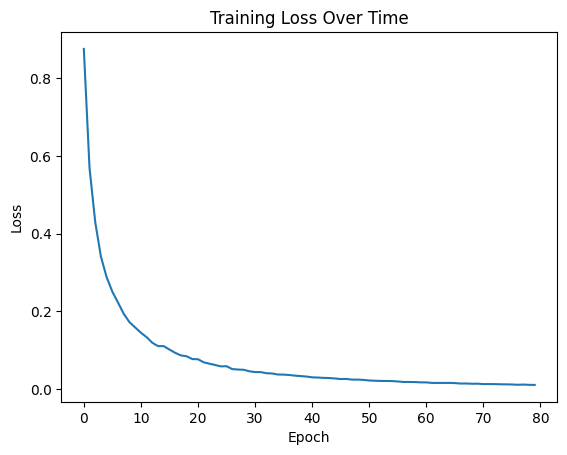

In [31]:
# Initialize and fit the trainable distance
L2Min_distance = L2MinDistance(input_dim = X_train.shape[1] , output_dim=64)
losses = L2Min_distance.fit(X_train, y_train)

# Plotting the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

 for the 0 th epoch, the loss is : 0.8801078796386719
 for the 10 th epoch, the loss is : 0.14580988883972168
 for the 20 th epoch, the loss is : 0.0767364352941513
 for the 30 th epoch, the loss is : 0.044373851269483566
 for the 40 th epoch, the loss is : 0.030800219625234604
 for the 50 th epoch, the loss is : 0.022463295608758926
 for the 60 th epoch, the loss is : 0.017675062641501427
 for the 70 th epoch, the loss is : 0.013348424807190895


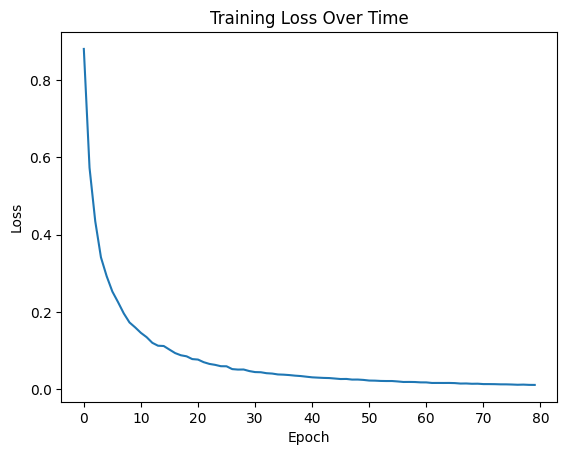

training error 0.14166666567325592
Validation error 0.8133333325386047
Accuracy: 0.18666667


In [38]:
L2Min_distance = L2MinDistance(input_dim = X_train.shape[1] , output_dim=64)
knearestneighbor = KNN(distance =L2Min_distance , k = 36)

losses = knearestneighbor.fit(X_train, y_train)
# Plotting the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()


y_hat = knearestneighbor.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))


y_hat_val = knearestneighbor.predict(X_val)

accuracy = (y_hat_val==y_val).mean()
err_v = (y_hat_val != y_val).mean()
print('Validation error {}'.format(err_v))

print("Accuracy:", accuracy)

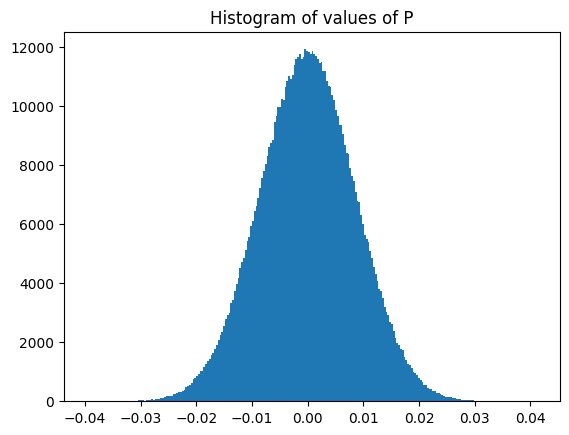

In [39]:
plt.hist(knearestneighbor.distance.P.flatten(), 250)
plt.title("Histogram of values of P")
plt.show()

<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>  The model clearly overfits, performing significantly better on the training set than on the validation set.
The loss is decreasing so nothing strange .
The minimization problem has an obvious solution: $P = 0$, which is evident from the histogram with $P$ centered at 0 with small variance. This suggests that the new space to which we are projecting leads to a loss of information.
While the distance metric helps to cluster data elements with the same label, it does not guarantee significant separation for dissimilar items, which can still affect decisions made by our KNN. This indicates that further improvements are necessary for better KNN performance.
To address this issue, we could modify the loss function that tends to assign values near 0 to matrix $P$. By adding two margins, $\alpha$ and $\beta$, we can ensure negligible cost contribution when $\|Px - Px_p\|^2 \leq \alpha$ for similar items ($y_p = y$) and zero when $\|Px - Px_n\|^2 \geq \beta$ for dissimilar items ($y_n \ne y$). This adjustment prevents the objective function from consistently driving $P$ towards 0.
</div>

The model clearly overfits, as it performs significantly better on the training set than on the validation set. However, the loss continues to decrease, which is not unusual in such cases.

The minimization problem has a trivial solution: $ P = 0 $, which is supported by the histogram of $ P $ values centered around zero. This indicates that the projection into the new space might be causing a loss of information.

Although the distance metric effectively clusters data elements with the same label, it fails to ensure significant separation between dissimilar items. This can adversely impact the decisions made by our KNN, suggesting that further enhancements are needed to improve KNN performance.

To address this issue, we can modify the loss function which currently drives the values of matrix $ P $ towards zero. By incorporating two margins, $ \alpha $ and $ \beta $, we can achieve a negligible cost contribution when the squared distance $ \|P x - P x_p\|^2 $ is less than or equal to $ \alpha $ for similar items (where $ y_p = y $), and zero cost when $ \|P x - P x_n\|^2 $ is greater than or equal to $ \beta $ for dissimilar items (where $ y_n \ne y $). These adjustments will prevent the loss function from consistently driving $ P $ towards zero, thereby retaining more information in the projected space.


## Contrastive loss

Next, we want to mitigate the tendancy of only minimizing the distance to collapse all samples to the same location.

<div class="alert alert-success"> <b>Q4.</b> Code a trainable distance function that minimizes the distance between related samples up to a margin and maximizes the distance between unrelated samples up to a margin:

$$\min_p \sum_{x, x_p, y = y_p} \max(0, \|Px - Px_p\|^2 - \alpha) - \lambda \sum_{x, x_n, y \neq y_n} \max(0, \beta - \|Px - Px_n\|^2) $$

Plot the loss value as the gradient descent progresses. To reduce the cost, perform the update on mini-batches of 50 samples taken randomly within the training set. Use again 64 output dimensions. <i>(Indicative time: 20 minutes to code, runs in about 45 seconds for 2000 iterations)</i>
</div>

In [26]:
class L2ContrastiveDistance(Distance):
    def __init__(self, input_dim, output_dim, alpha=0.1, beta= 0.95, lambd=0.75) :
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.alpha = alpha
        self.beta = beta
        self.lambd = lambd
    @staticmethod
    @jax.jit
    def dist(X1, X2):
        norms1 = jnp.sum(jnp.square(X1), axis=1)
        norms2 = jnp.sum(jnp.square(X2), axis=1)
        D =  jnp.dot(X1, X2.T)
        return (norms2[None,:] + norms1[:,None] - 2*D)


    @staticmethod
    @jax.jit
    def loss(P, X, y, alpha, beta, lambd):
        # Project all data points
        X_projected = X @ P
        # Calculate pairwise differences using broadcasting
        sq_distances = L2ContrastiveDistance.dist(X_projected, X_projected)
        # Create a mask where both samples have the same label
        same_label = y[:, None] == y[None, :]#jnp.transpose
        loss = jnp.mean(jnp.maximum(0,(sq_distances-alpha) * same_label)) + lambd *jnp.mean(jnp.maximum(0,(beta - sq_distances) * ~same_label))
        return loss

    @staticmethod
    @jax.jit
    def update(P, X, y, alpha, beta, lambd, eta=0.05):
        l, dp = jax.value_and_grad(L2ContrastiveDistance.loss, argnums=0)(P, X, y, alpha, beta, lambd)
        return l, P - eta*dp


    def fit(self, X, y):
          N= len(y)
          num_batches = (N+ 50 -1)//50
          losses = jnp.zeros(100)
          for i in range(100): #80
              perm_indices = jax.random.permutation(jax.random.PRNGKey(i), N)
              epoch_losses = []
              for k in range(num_batches) :
                      indices = perm_indices[k*50 : min((k+1)*50,N)]
                      batch_loss, self.P = self.update(self.P, X[indices], y[indices],self.alpha,self.beta,self.lambd)
                      epoch_losses.append(batch_loss)

              mean_loss = jnp.mean(jnp.array(epoch_losses))
              if i%10 == 0 :
                print(f' for the {i} th epoch, the loss is : {mean_loss}')
              epoch_losses.append(mean_loss)
              losses = losses.at[i].set(mean_loss)


          return losses


    def predict(self, X1, X2):
        X1_projected = X1 @ self.P
        X2_projected = X2 @ self.P
        return L2ContrastiveDistance.dist( X1_projected,  X2_projected)



In [27]:
%%time
L2constrastive_distance = L2ContrastiveDistance(input_dim = X_train.shape[1] , output_dim=64)
knearestneighbor = KNN(distance = L2constrastive_distance , k = 36)
losses = knearestneighbor.fit(X_train, y_train)

y_hat = knearestneighbor.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))


y_hat_val = knearestneighbor.predict(X_val)
accuracy = (y_hat_val==y_val).mean()
err_v = (y_hat_val != y_val).mean()
print('Validation error {}'.format(err_v))

print("Accuracy (val):", accuracy)

 for the 0 th epoch, the loss is : 0.8279134035110474
 for the 10 th epoch, the loss is : 0.08085059374570847
 for the 20 th epoch, the loss is : 0.05005839094519615
 for the 30 th epoch, the loss is : 0.021288467571139336
 for the 40 th epoch, the loss is : 0.007437897380441427
 for the 50 th epoch, the loss is : 1.1714137144736014e-05
 for the 60 th epoch, the loss is : 8.71230622578878e-06
 for the 70 th epoch, the loss is : 4.0965704783957335e-07
 for the 80 th epoch, the loss is : 1.4262148795296525e-08
 for the 90 th epoch, the loss is : 1.5659480823160266e-07
training error 0.0
Validation error 0.46666666865348816
Accuracy (val): 0.53333336
CPU times: user 20.4 s, sys: 320 ms, total: 20.7 s
Wall time: 14.6 s


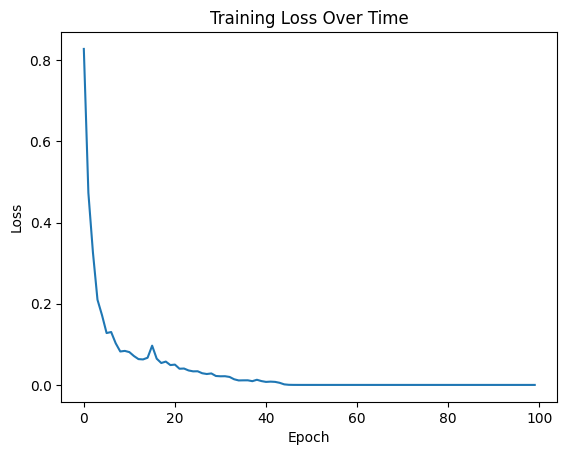

In [28]:
# Plotting the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>
Accuracy on the validation set is 0.51 and 0 training loss is acceptable and better than the previous results.
We still need to enhance the model to achieve better results. There is overfitting with this particular choice of hyperparameters, because the performance is good on the training set but worse on the validation set!

</div>

## Triplet loss and non-linear projection

There is nothing in the goals of metric learning that prevents us from using a non-linear projection $\phi(\cdot)$. On the contrary, using a non linear could allow us to have a mapping that contains implicit boundaries where on the one side samples would be pushed towards one direction, while on the other side they would be pushed towards another direction. To test this idea, we will use a simple non-linear mapping implemeted by a 2 layer MLP, which corresponds to the following formula:

$$ \phi(x) = P_2 [ P_1 x + b_1]_+ $$
with $[\cdot]_+$ the ReLU function.
Instead of a single trainable argument, our projection method has 3 ($P_1, b_1, P_2$) and thus our loss function should also have 3, and the `argnums` argment of the gradient computation should also reflect this change (`argnums=(0,1,2)` for example).

In addition, since $k$NN is in nature using a ranking approach by sorting the samples, we will know consider a loss function that enforces the order of the samples rather than their absolute distance values.

$$ \min_\phi \sum_{\phi(x), \phi(x_p), \phi(x_n), y = y_p, y \neq y_n} \max(0, \alpha + \|\phi(x) - \phi(x_p)\|^2 - \|\phi(x) - \phi(x_n)\|^2) $$

<div class="alert alert-success"> <b>Q5.</b> Code the non-linear triplet loss based trainable distance function. Similarly to other trainable distances, perform the update on mini-batches of size 50. Use a hidden size of 256 and again 64 output dimensions. <i>(Indicative time: 50 minutes to code, runs in about 2 minutes for 2000 iterations) and significantly improve the validation accuracy)</i>
</div>

In [29]:
class L2TripletDistance(Distance):
    def __init__(self, input_dim, hidden_dim ,output_dim, alpha=0.7):
        super().__init__()
        self.P1 = np.random.randn(input_dim, hidden_dim)/jnp.sqrt(input_dim+hidden_dim)
        self. b1 = np.zeros(hidden_dim)
        self.P2 = np.random.randn(hidden_dim, output_dim)/jnp.sqrt(hidden_dim+output_dim)
        self.alpha = alpha


    @staticmethod
    @jax.jit
    def dist(X1, X2):
        norms1 = jnp.sum(jnp.square(X1), axis=1)
        norms2 = jnp.sum(jnp.square(X2), axis=1)
        D =  jnp.dot(X1, X2.T)
        return (norms2[None,:] + norms1[:,None] - 2*D)

    @staticmethod
    @jax.jit
    def project(P1, b1, P2, X):
        return (jnp.maximum(0,(X @ P1 + b1[None, :]))) @ P2


    @staticmethod
    @jax.jit
    def loss(P1, b1, P2, X, y, alpha):
        # Project all data points
        X_projected = L2TripletDistance.project(P1, b1, P2,X)
        sq_distances = L2TripletDistance.dist(X_projected, X_projected)
        mask = y[:, None] == y[None, :]
        mask_d = ~mask
        S2 = sq_distances[:,None,:]
        S1 = sq_distances[:,:,None]
        f = (S1 - S2 + alpha)*mask[:,:,None]*mask_d[:,None,:]
        loss = jnp.mean(jnp.maximum(f, 0))
        return loss


    @staticmethod
    def update(P1, b1, P2, X, y, alpha, eta=0.05):
        l, dp = jax.value_and_grad(L2TripletDistance.loss, argnums=(0,1,2))(P1,b1,P2, X, y, alpha)
        dp1 , db1 , dp2 = dp
        return l, P1 - eta*dp1 , b1 - eta*db1, P2 - eta*dp2

    def fit(self, X, y):
          N= len(y)
          num_batches = (N+ 50 -1)//50
          losses = jnp.zeros(100)
          for i in range(100):
              perm_indices = jax.random.permutation(jax.random.PRNGKey(i), N)
              epoch_losses = []
              for k in range(num_batches) :
                      indices = perm_indices[k*50 : min((k+1)*50,N)]
                      batch_loss, self.P1, self.b1, self.P2 = self.update(self.P1, self.b1, self.P2, X[indices], y[indices],self.alpha)
                      epoch_losses.append(batch_loss)
              mean_loss = jnp.mean(jnp.array(epoch_losses))
              epoch_losses.append(mean_loss)
              losses = losses.at[i].set(mean_loss)
              if i%20 ==0:
                    print(f' for the {i} th epoch, the loss is : {mean_loss}')
          return losses

    def predict(self, X1, X2):
        X1_projected = L2TripletDistance.project(self.P1, self.b1,self.P2,X1)
        X2_projected = L2TripletDistance.project(self.P1, self.b1,self.P2,X2)
        return L2TripletDistance.dist(X1_projected,X2_projected)

 for the 0 th epoch, the loss is : 0.028716322034597397
 for the 20 th epoch, the loss is : 0.0030486732721328735
 for the 40 th epoch, the loss is : 0.0008151921210810542
 for the 60 th epoch, the loss is : 0.0003872152592521161
 for the 80 th epoch, the loss is : 0.00018793453637044877


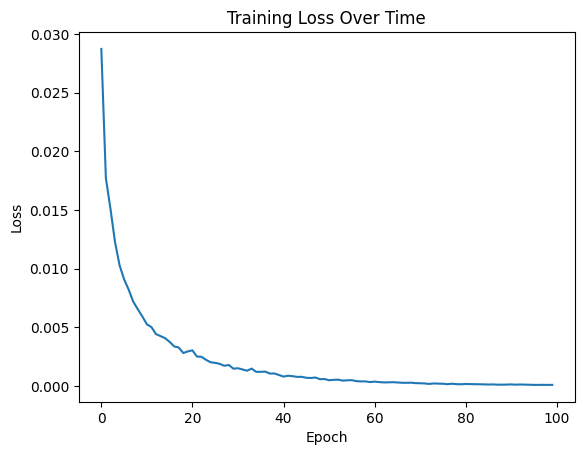

training error 0.0
Validation error 0.25
Accuracy (val): 0.75
CPU times: user 1min 37s, sys: 658 ms, total: 1min 37s
Wall time: 1min 5s


In [34]:
%%time
L2triplet_distance = L2TripletDistance(input_dim = X_train.shape[1] ,hidden_dim = 256 , output_dim=64)
knearestneighbor = KNN(distance = L2triplet_distance , k = 36)
losses = knearestneighbor.fit(X_train, y_train)


# Plotting the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

y_hat = knearestneighbor.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))

y_hat_val = knearestneighbor.predict(X_val)
accuracy = (y_hat_val==y_val).mean()
err_v = (y_hat_val != y_val).mean()
print('Validation error {}'.format(err_v))
print("Accuracy (val):", accuracy)

<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>
The non-linearity has significantly improved the model compared to previous ones, and the increased number of parameters now better captures the similarities and differences. MILP is a suitable choice for detecting these, but I expected more from the KNN, even though 73% accuracy is the best we have achieved.
The new projection function effectively encodes what we intended. The performance here surpasses that achieved with contrastive loss because the distance between $x$ and $x_p$ also influences the distance between $x$ and $x_n$. This provides a better understanding of the similarities. In contrastive loss, there wasn't a mechanism to ensure both parts of the loss are minimized simultaneously; the parameter $\alpha$ always favors the positive loss, as we primarily want to enhance the similarities to improve KNN results.
However, we are still experiencing overfitting, as the training error is zero whereas the validation error is 25%.
</div>

<div class="alert alert-warning"> <b>Q6.</b> Perform a proper cross-validation on the $\alpha$ parameter.</i>
</div>

In [ ]:
margin_values = np.linspace(0.1,2,15) #[0.1, 0.7, 2]


input_dim = X_train.shape[1]
output_dim = 65
hidden_dim = 256
k=36


errors_train = np.zeros(len(margin_values))
errors_val = np.zeros(len(margin_values))

for i in range (len(margin_values)) :
      print("we are in the ", i ,"th margin value.")
      knn = KNN(L2TripletDistance(input_dim, hidden_dim , output_dim, margin_values[i]), k)
      knn.fit(X_train, y_train)
      y_hat = knn.predict(X_train)
      errors_train[i] = (y_hat != y_train).mean()
      y_hat = knn.predict(X_val)
      errors_val[i] = (y_hat != y_val).mean()


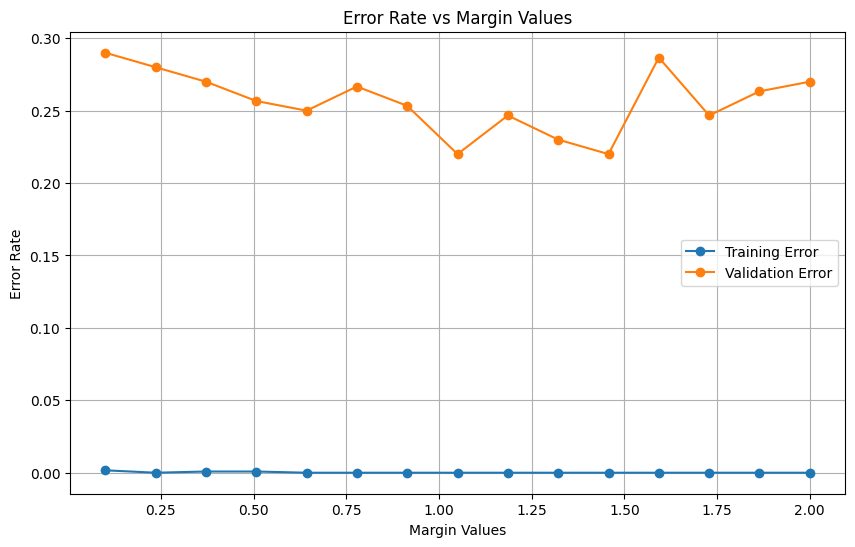

In [24]:
# Plot the errors as a function of the margin
plt.figure(figsize=(10, 6))
plt.plot(margin_values, errors_train, label='Training Error', marker='o')
plt.plot(margin_values, errors_val, label='Validation Error', marker='o')
plt.xlabel('Margin Values')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Margin Values')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Find the indices of the minimum validation error
min_val_error_idx =jnp.argmin(errors_val)
# Get the corresponding best hyperparameters
best_margin = margin_values[min_val_error_idx]

print(f'Best hyperparameters:\nMargin: {best_margin} .')

print(f'That has a trainin error : {errors_train[min_val_error_idx]} ')
print(f'The best accuracy until now is , {100*(1 -errors_val[min_val_error_idx])} %')

Best hyperparameters:
Margin: 1.05 .
That has a trainin error : 0.0 
The best accuracy until now is , 78.00000011920929 %


<div class="alert alert-info" role="alert"><b>Analyze your results in this box.</b>  Training error is almost zero across all margins, indicating overfitting; however, it is evident that $\alpha$ has an influence on validation accuracy. The margin $\alpha$ serves as a threshold to ensure that the negative example is farther from the anchor than the positive example by at least $\alpha$ units.
Choosing an appropriate margin $\alpha$ is crucial:
1.   If $\alpha$ is too small, the network might not learn a strong enough separation between classes, leading to poor performance.
2.    If $\alpha$ is too large, it might be overly difficult for the network to satisfy the triplet constraint, leading to slow convergence or poor training.
The optimal $\alpha$ (among the 15 values we tested) is 1.05, achieving 78% accuracy on the validation set.

</div>
